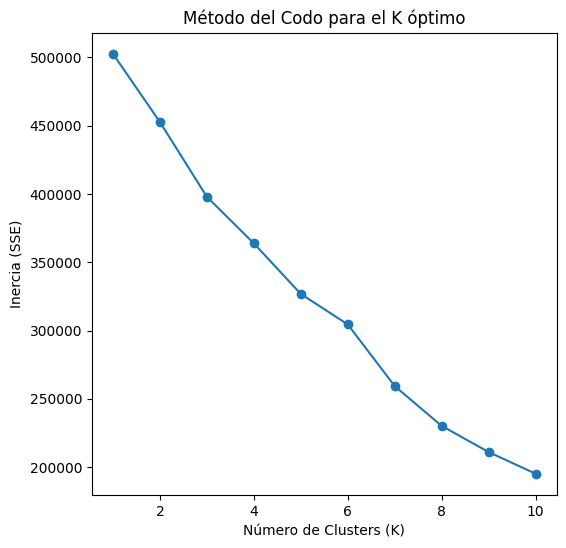

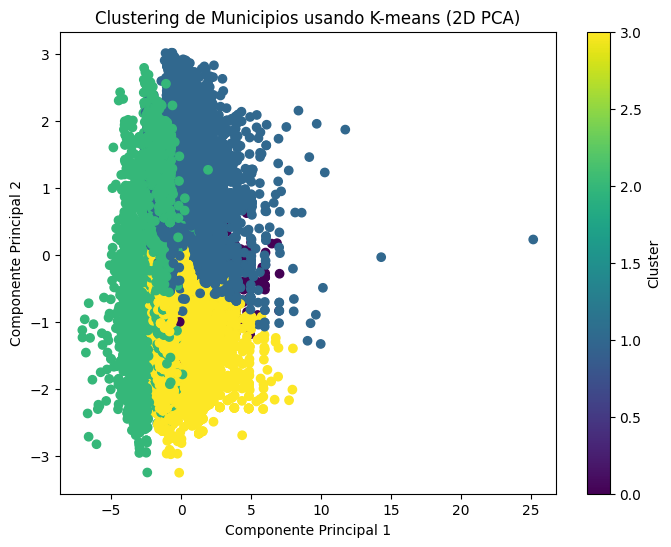

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Cargar archivos y concatenar
archivos = ["2017.csv", "2018.csv", "2019.csv", "2020.csv", "2021.csv", "2022.csv", "2023.csv", "2024.csv"]
columnas_estandar = [
    'DEPARTAMENTO', 'MUNICIPIO', 'CODIGO DANE', 'ARMA MEDIO', 
    'FECHA HECHO', 'GENERO', 'AGRUPA EDAD', 'CANTIDAD'
]
def cargar_y_reordenar_csv(archivo, columnas_estandar):
    df = pd.read_csv(archivo)
    df = df.reindex(columns=columnas_estandar)
    return df
dfs = [cargar_y_reordenar_csv(archivo, columnas_estandar) for archivo in archivos]
df_total = pd.concat(dfs, ignore_index=True)

# Rellenar valores faltantes en 'CANTIDAD'
df_total['CANTIDAD'] = df_total['CANTIDAD'].fillna(1)

# Convertir 'FECHA HECHO' a tipo datetime
df_total['FECHA HECHO'] = pd.to_datetime(df_total['FECHA HECHO'], errors='coerce')

# Extraer año y mes de la fecha
df_total['AÑO'] = df_total['FECHA HECHO'].dt.year
df_total['MES'] = df_total['FECHA HECHO'].dt.month

# Eliminar filas con fechas no válidas
df_total = df_total.dropna(subset=['FECHA HECHO'])

# Codificar variables categóricas con LabelEncoder
le_departamento = LabelEncoder()
le_municipio = LabelEncoder()
le_arma_medio = LabelEncoder()
le_genero = LabelEncoder()
le_agrupa_edad = LabelEncoder()

df_total['DEPARTAMENTO'] = le_departamento.fit_transform(df_total['DEPARTAMENTO'])
df_total['MUNICIPIO'] = le_municipio.fit_transform(df_total['MUNICIPIO'])
df_total['ARMA MEDIO'] = le_arma_medio.fit_transform(df_total['ARMA MEDIO'])
df_total['GENERO'] = le_genero.fit_transform(df_total['GENERO'])
df_total['AGRUPA EDAD'] = le_agrupa_edad.fit_transform(df_total['AGRUPA EDAD'])

# Seleccionar las columnas para el clustering
features = ['DEPARTAMENTO', 'MUNICIPIO', 'ARMA MEDIO', 'GENERO', 'AGRUPA EDAD', 'AÑO', 'MES', 'CANTIDAD']

# Normalizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_total[features])

# Método del codo para determinar el número de clusters óptimo
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(6, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del Codo para el K óptimo')
plt.show()

# Entrenar el modelo K-means con el número de clusters óptimo (asumimos K=4 aquí como ejemplo)
kmeans = KMeans(n_clusters=4, random_state=42)
df_total['Cluster'] = kmeans.fit_predict(df_scaled)

# Graficar los resultados de K-means usando PCA para reducción de dimensiones
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_total['Cluster'], cmap='viridis')
plt.title('Clustering de Municipios usando K-means (2D PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()


In [25]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

# Carga de archivos
columnas_estandar = [
    'DEPARTAMENTO', 'MUNICIPIO', 'CODIGO DANE', 'ARMA MEDIO', 
    'FECHA HECHO', 'GENERO', 'AGRUPA EDAD', 'CANTIDAD'
]

def cargar_y_reordenar_csv(archivo, columnas_estandar):
    df = pd.read_csv(archivo)
    df = df.reindex(columns=columnas_estandar)
    return df

archivos = ["2017.csv", "2018.csv", "2019.csv", "2020.csv", "2021.csv", "2022.csv", "2023.csv", "2024.csv"]
dfs = [cargar_y_reordenar_csv(archivo, columnas_estandar) for archivo in archivos]

df_total = pd.concat(dfs, ignore_index=True)
shapefile_path = './Municipios_shp/Municipio, Distrito y Área no municipalizada.shp' 
colombia_map = gpd.read_file(shapefile_path)


df_total['CANTIDAD'] = df_total['CANTIDAD'].fillna(1)
df_total['CANTIDAD'] = pd.to_numeric(df_total['CANTIDAD'], errors='coerce')

mp_codigo_list = []  

for municipio in df_total['MUNICIPIO']:
    municipio_lower = municipio.lower()  
    print(type(municipio_lower))
  
    # codigo = colombia_map.loc[colombia_map['MpNombre'].str.lower().str.contains(municipio_lower, na=False), 'MpCodigo']
    
    # if not codigo.empty:
    #     mp_codigo_list.append(codigo.iloc[0])  
    # else:
    #     mp_codigo_list.append(None)  

print(mp_codigo_list)       
# df_total['MpCodigo'] = mp_codigo_list


# grouped_data = df_total.groupby(['CODIGO DANE', 'DEPARTAMENTO', 'MUNICIPIO'], as_index=False).sum()

# Paso 3: Cargar el shapefile de los municipios de Colombia (límite geográfico)
# Suponiendo que tenemos un archivo .shp descargado de municipios colombianos
df = pd.DataFrame() 
#df['MUNICIPIO'] = df_total['MUNICIPIO'].drop_duplicates()
df['MpNombre'] = colombia_map['MpNombre']
#resultado = colombia_map[colombia_map['MpNombre'].str.contains('Cartagena', case=False, na=False)]
#resultado
df.to_csv('comparar.csv')

# df_total['MUNICIPIO_lower'] = df_total['MUNICIPIO'].str.lower()
# colombia_map['MpNombre_lower'] = colombia_map['MpNombre'].str.lower()

# Hacer un merge basado en los nombres de municipios en minúsculas
# df_total = df_total.merge(colombia_map[['MpNombre_lower', 'MpCodigo']], 
#                           left_on='MUNICIPIO_lower', 
#                           right_on='MpNombre_lower', 
#                           how='left')

# Eliminar las columnas temporales que ya no son necesarias
# df_total.drop(columns=['MUNICIPIO_lower', 'MpNombre_lower'], inplace=True)
# Paso 4: Hacer la unión de los datos de homicidios con la geometría de los municipios
# Suponiendo que el shapefile tiene una columna 'CODIGO DANE'
# colombia_map = colombia_map.merge(grouped_data, on='CODIGO DANE', how='left')

# df_total['MpCodigo']

# # Paso 5: Crear un mapa base usando Folium
# colombia_mapa_interactivo = folium.Map(location=[4.5709, -74.2973], zoom_start=6)

# # Paso 6: Añadir los datos al mapa interactivo
# # Crear una capa de municipios coloreados en base a la cantidad de homicidios
# choropleth = folium.Choropleth(
#     geo_data=colombia_map.to_json(),
#     name='choropleth',
#     data=colombia_map,
#     columns=['CODIGO DANE', 'CANTIDAD'],
#     key_on='feature.properties.CODIGO DANE',
#     fill_color='YlOrRd',
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Número de Homicidios por Municipio'
# ).add_to(colombia_mapa_interactivo)

# # Añadir una capa de control para permitir al usuario alternar capas
# folium.LayerControl().add_to(colombia_mapa_interactivo)

# # Paso 7: Guardar el mapa interactivo como un archivo HTML
# colombia_mapa_interactivo.save('mapa_homicidios_colombia.html')

# # Mostrar el mapa interactivo
# colombia_mapa_interactivo


C:\Users\ahurt\AppData\Local\Temp\ipykernel_14520\1420794781.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  codigo = colombia_map.loc[colombia_map['MpNombre'].str.lower().str.contains(municipio_lower, na=False), 'MpCodigo']


AttributeError: 'float' object has no attribute 'lower'